# 결측치 처리 분석

이 노트북은 기업 재무 데이터에서 결측치를 처리하는 코드입니다.

**처리 규칙:**
- 각 열에서 데이터가 80% 이상 있으면 → 결측치를 중앙값으로 대체
- 각 열에서 데이터가 80% 미만이면 → 해당 연도의 행을 제거


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기준
plt.rcParams['axes.unicode_minus'] = False

In [11]:
# 데이터 로드
df = pd.read_csv('ts2000_with_default_flag.csv')

print(f"원본 데이터 크기: {df.shape}")
print(f"총 행 수: {len(df)}")
print(f"총 열 수: {len(df.columns)}")
print("\n데이터 타입:")
print(df.dtypes)

원본 데이터 크기: (21833, 51)
총 행 수: 21833
총 열 수: 51

데이터 타입:
Unnamed: 0        float64
corp_nm            object
stock_code          int64
year                int64
자산총계_당기           float64
자산총계_전기           float64
비유동자산_당기          float64
비유동자산_전기          float64
유동자산_당기           float64
유동자산_전기           float64
자본총계_당기           float64
자본총계_전기           float64
자본금_당기            float64
자본금_전기            float64
이익잉여금_당기          float64
이익잉여금_전기          float64
부채총계_당기           float64
부채총계_전기           float64
비유동부채_당기          float64
비유동부채_전기          float64
유동부채_당기           float64
유동부채_전기           float64
현금및현금성자산_당기       float64
현금및현금성자산_전기       float64
영업활동현금흐름_당기       float64
영업활동현금흐름_전기       float64
투자활동현금흐름_당기       float64
투자활동현금흐름_전기       float64
재무활동현금흐름_당기       float64
재무활동현금흐름_전기       float64
매출액_당기            float64
매출액_전기            float64
매출총이익_당기          float64
매출총이익_전기          float64
판매관리비_당기          float64
판매관리비_전기          float64
영업이익_당기  

In [12]:
# 결측치 현황 분석
def analyze_missing_data(df):
    """
    데이터프레임의 결측치 현황을 분석하는 함수
    """
    missing_info = pd.DataFrame({
        '결측치_개수': df.isnull().sum(),
        '결측치_비율': (df.isnull().sum() / len(df)) * 100,
        '데이터_개수': df.count(),
        '데이터_비율': (df.count() / len(df)) * 100
    })
    
    # 결측치가 있는 열만 필터링
    missing_info = missing_info[missing_info['결측치_개수'] > 0]
    missing_info = missing_info.sort_values('결측치_개수', ascending=False)
    
    return missing_info

# 원본 데이터의 결측치 현황
missing_analysis = analyze_missing_data(df)
print("=== 원본 데이터 결측치 현황 ===")
if len(missing_analysis) > 0:
    print(missing_analysis)
else:
    print("결측치가 없습니다.")

print(f"\n결측치가 있는 열의 수: {len(missing_analysis)}")

=== 원본 데이터 결측치 현황 ===
결측치가 없습니다.

결측치가 있는 열의 수: 0


In [13]:
# 결측치 시각화 (결측치가 있는 경우에만)
if len(missing_analysis) > 0:
    plt.figure(figsize=(12, 8))
    
    # 상위 20개 열만 표시
    top_missing = missing_analysis.head(20)
    
    plt.subplot(2, 1, 1)
    top_missing['결측치_개수'].plot(kind='bar')
    plt.title('열별 결측치 개수')
    plt.xticks(rotation=45)
    plt.ylabel('결측치 개수')
    
    plt.subplot(2, 1, 2)
    top_missing['결측치_비율'].plot(kind='bar', color='orange')
    plt.title('열별 결측치 비율 (%)')
    plt.xticks(rotation=45)
    plt.ylabel('결측치 비율 (%)')
    plt.axhline(y=20, color='red', linestyle='--', label='80% 데이터 기준선')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("결측치가 없어서 시각화를 생략합니다.")

결측치가 없어서 시각화를 생략합니다.


In [14]:
def process_missing_data(df, threshold=0.8):
    """
    결측치 처리 함수
    
    Parameters:
    df: 처리할 데이터프레임
    threshold: 데이터 비율 임계값 (기본값: 0.8 = 80%)
    
    Returns:
    processed_df: 처리된 데이터프레임
    processing_log: 처리 과정 로그
    """
    
    df_processed = df.copy()
    processing_log = []
    total_rows = len(df_processed)
    
    print(f"=== 결측치 처리 시작 (임계값: {threshold*100}%) ===")
    print(f"원본 데이터: {df_processed.shape}")
    
    # 각 열별로 결측치 비율 계산
    missing_ratios = df_processed.isnull().sum() / len(df_processed)
    data_ratios = 1 - missing_ratios
    
    # 1단계: 데이터 비율이 임계값 미만인 열들을 가진 행 제거
    columns_to_remove_rows = []
    for col in df_processed.columns:
        if data_ratios[col] < threshold and missing_ratios[col] > 0:
            columns_to_remove_rows.append(col)
            processing_log.append(f"열 '{col}': 데이터 비율 {data_ratios[col]*100:.1f}% < {threshold*100}% → 결측치 있는 행 제거")
    
    if columns_to_remove_rows:
        print(f"\n데이터 비율이 {threshold*100}% 미만인 열들: {len(columns_to_remove_rows)}개")
        for col in columns_to_remove_rows:
            print(f"  - {col}: {data_ratios[col]*100:.1f}%")
        
        # 이러한 열들에서 결측치가 있는 행들을 제거
        rows_to_drop = set()
        for col in columns_to_remove_rows:
            missing_rows = df_processed[df_processed[col].isnull()].index
            rows_to_drop.update(missing_rows)
        
        df_processed = df_processed.drop(rows_to_drop)
        print(f"제거된 행 수: {len(rows_to_drop)}")
        print(f"남은 데이터: {df_processed.shape}")
    else:
        print(f"\n데이터 비율이 {threshold*100}% 미만인 열이 없습니다.")
    
    # 2단계: 데이터 비율이 임계값 이상인 열들의 결측치를 중앙값으로 대체
    columns_to_impute = []
    for col in df_processed.columns:
        current_data_ratio = df_processed[col].count() / len(df_processed)
        if current_data_ratio >= threshold and df_processed[col].isnull().sum() > 0:
            # 숫자형 열만 중앙값으로 대체
            if df_processed[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                columns_to_impute.append(col)
                processing_log.append(f"열 '{col}': 데이터 비율 {current_data_ratio*100:.1f}% >= {threshold*100}% → 중앙값으로 대체")
    
    if columns_to_impute:
        print(f"\n중앙값으로 대체할 열들: {len(columns_to_impute)}개")
        for col in columns_to_impute:
            missing_count = df_processed[col].isnull().sum()
            if missing_count > 0:
                median_value = df_processed[col].median()
                df_processed[col].fillna(median_value, inplace=True)
                print(f"  - {col}: {missing_count}개 결측치를 중앙값 {median_value}로 대체")
    else:
        print(f"\n중앙값으로 대체할 열이 없습니다.")
    
    print(f"\n=== 처리 완료 ===")
    print(f"최종 데이터: {df_processed.shape}")
    print(f"제거된 행 수: {total_rows - len(df_processed)}")
    
    return df_processed, processing_log

# 결측치 처리 실행
df_processed, log = process_missing_data(df, threshold=0.8)

print("\n=== 처리 로그 ===")
for entry in log:
    print(entry)

=== 결측치 처리 시작 (임계값: 80.0%) ===
원본 데이터: (21833, 51)

데이터 비율이 80.0% 미만인 열이 없습니다.

중앙값으로 대체할 열이 없습니다.

=== 처리 완료 ===
최종 데이터: (21833, 51)
제거된 행 수: 0

=== 처리 로그 ===


In [15]:
# 처리 후 결측치 현황 확인
print("=== 처리 후 결측치 현황 ===")
missing_after = analyze_missing_data(df_processed)

if len(missing_after) > 0:
    print(missing_after)
else:
    print("모든 결측치가 처리되었습니다!")

print(f"\n처리 전후 비교:")
print(f"원본 데이터: {df.shape}")
print(f"처리 후 데이터: {df_processed.shape}")
print(f"제거된 행 수: {len(df) - len(df_processed)}")
print(f"제거된 행 비율: {((len(df) - len(df_processed)) / len(df)) * 100:.2f}%")

=== 처리 후 결측치 현황 ===
모든 결측치가 처리되었습니다!

처리 전후 비교:
원본 데이터: (21833, 51)
처리 후 데이터: (21833, 51)
제거된 행 수: 0
제거된 행 비율: 0.00%


=== 연도별 데이터 분포 ===
       처리전   처리후  제거된_행수  제거비율(%)
year                             
2015  2282  2282       0      0.0
2016  2327  2327       0      0.0
2017  2393  2393       0      0.0
2018  2421  2421       0      0.0
2019  2467  2467       0      0.0
2020  2491  2491       0      0.0
2021  2497  2497       0      0.0
2022  2486  2486       0      0.0
2023  2469  2469       0      0.0


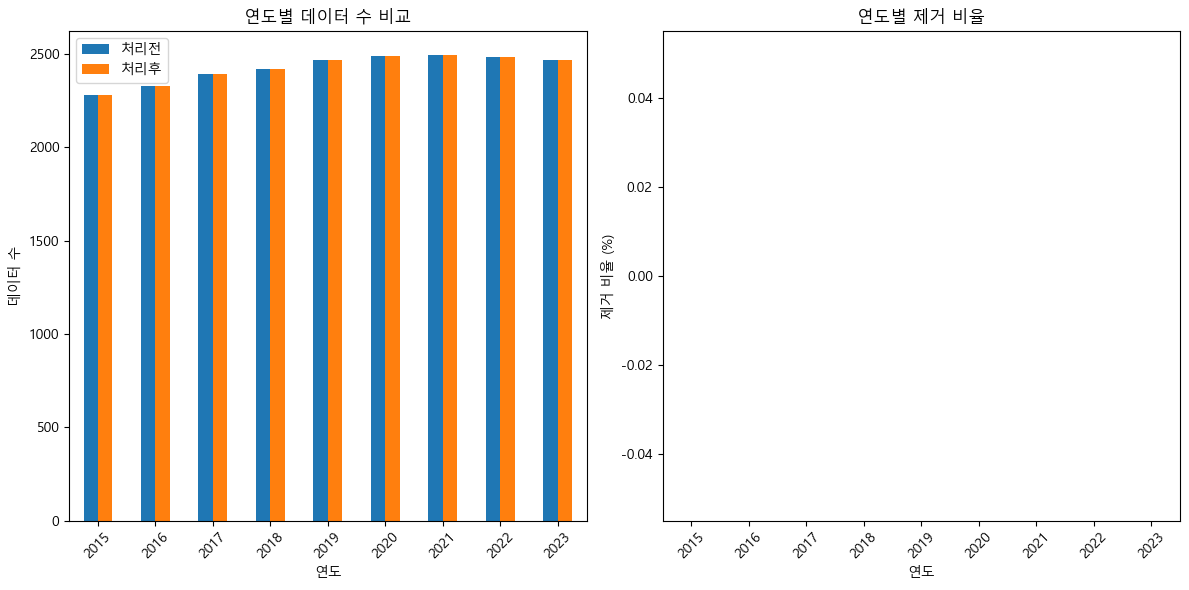

In [16]:
# 연도별 데이터 분포 확인
if 'year' in df_processed.columns:
    print("=== 연도별 데이터 분포 ===")
    
    year_dist_before = df['year'].value_counts().sort_index()
    year_dist_after = df_processed['year'].value_counts().sort_index()
    
    comparison_df = pd.DataFrame({
        '처리전': year_dist_before,
        '처리후': year_dist_after,
    }).fillna(0)
    
    comparison_df['제거된_행수'] = comparison_df['처리전'] - comparison_df['처리후']
    comparison_df['제거비율(%)'] = (comparison_df['제거된_행수'] / comparison_df['처리전'] * 100).round(2)
    
    print(comparison_df)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    comparison_df[['처리전', '처리후']].plot(kind='bar', ax=plt.gca())
    plt.title('연도별 데이터 수 비교')
    plt.xlabel('연도')
    plt.ylabel('데이터 수')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    comparison_df['제거비율(%)'].plot(kind='bar', color='red', ax=plt.gca())
    plt.title('연도별 제거 비율')
    plt.xlabel('연도')
    plt.ylabel('제거 비율 (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [17]:
# 처리된 데이터 저장
output_filename = 'ts2000_processed_missing_data.csv'
df_processed.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"처리된 데이터가 '{output_filename}'로 저장되었습니다.")

# 기본 통계량 확인
print("\n=== 처리된 데이터 기본 통계량 ===")
print(df_processed.describe())

처리된 데이터가 'ts2000_processed_missing_data.csv'로 저장되었습니다.

=== 처리된 데이터 기본 통계량 ===
         Unnamed: 0     stock_code          year       자산총계_당기       자산총계_전기  \
count  21833.000000   21833.000000  21833.000000  2.183300e+04  2.183300e+04   
mean   11993.869235  127516.028031   2019.068841  6.992588e+08  6.632701e+08   
std     6936.443917  136836.603273      2.565570  2.738833e+09  2.620893e+09   
min      121.160000     230.000000   2015.000000  7.899882e+06  7.935010e+06   
25%     5992.000000   28050.000000   2017.000000  7.077242e+07  7.215706e+07   
50%    11980.000000   79370.000000   2019.000000  1.383309e+08  1.351178e+08   
75%    18005.000000  205500.000000   2021.000000  3.141785e+08  2.909353e+08   
max    23909.840000  900140.000000   2023.000000  2.800193e+10  2.701703e+10   

           비유동자산_당기      비유동자산_전기       유동자산_당기       유동자산_전기       자본총계_당기  \
count  2.183300e+04  2.183300e+04  2.183300e+04  2.183300e+04  2.183300e+04   
mean   4.622822e+08  4.379855e+08  2.35636

In [18]:
# 결측치 처리 함수를 별도로 정의 (재사용 가능)
def clean_financial_data(filepath, threshold=0.8, save_output=True):
    """
    재무 데이터의 결측치를 처리하는 통합 함수
    
    Parameters:
    filepath: CSV 파일 경로
    threshold: 데이터 비율 임계값 (기본값: 0.8)
    save_output: 결과 저장 여부 (기본값: True)
    
    Returns:
    cleaned_data: 처리된 데이터프레임
    """
    
    # 데이터 로드
    df = pd.read_csv(filepath)
    print(f"데이터 로드 완료: {df.shape}")
    
    # 결측치 처리
    df_cleaned, _ = process_missing_data(df, threshold)
    
    # 저장
    if save_output:
        output_name = filepath.replace('.csv', '_cleaned.csv')
        df_cleaned.to_csv(output_name, index=False, encoding='utf-8-sig')
        print(f"정리된 데이터 저장: {output_name}")
    
    return df_cleaned

print("결측치 처리 함수가 정의되었습니다.")
print("사용법: clean_financial_data('파일명.csv', threshold=0.8)")

결측치 처리 함수가 정의되었습니다.
사용법: clean_financial_data('파일명.csv', threshold=0.8)
